In [101]:
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Exercise 1

In [2]:
def agglomerativeClustering(D, dist, k=1):
    C = [[i] for i in range(len(D))]

    while len(C) > k:
        distances = np.zeros((len(C), len(C)))
        for i in range(len(C)):
            for j in range(i + 1, len(C)):
                distances[i][j] = dist(D, C[i], C[j])
                distances[j][i] = distances[i][j]

        min_dist = np.inf
        min_i, min_j = None, None

        for i in range(len(C)):
            for j in range(i + 1, len(C)):
                if distances[i][j] < min_dist:
                    min_dist = distances[i][j]
                    min_i, min_j = i, j

        Ci, Cj = C[min_i], C[min_j]
        Cij = []
        Cij.extend(Ci)
        Cij.extend(Cj)

        C.remove(Ci)
        C.remove(Cj)
        C.append(Cij)

    C.sort(key=sortFunction)
    cluster_ids = [-1] * len(D)
    for i, cluster in enumerate(C):
        for point in cluster:
            cluster_ids[point] = i

    return cluster_ids

def sortFunction(elem):
    return min(elem)

In [3]:
def singleLink(D, Ci, Cj):
    min_dist = np.inf
    for i in Ci:
        for j in Cj:
            dist_ij = np.linalg.norm(D[i] - D[j])
            if dist_ij < min_dist:
                min_dist = dist_ij
    return min_dist

In [4]:
def completeLink(D, Ci, Cj):
    max_dist = 0
    for i in Ci:
        for j in Cj:
            dist_ij = np.linalg.norm(D[i] - D[j])
            if dist_ij > max_dist:
                max_dist = dist_ij
    return max_dist

In [5]:
def groupAverage(D, Ci, Cj):
    distance_sum = 0

    D_i = [D[i] for i in Ci]
    D_j = [D[i] for i in Cj]

    for point_i in D_i:
        for point_j in D_j:
            distance_sum += np.linalg.norm(point_i - point_j)

    return distance_sum / (len(D_i) * len(D_j))

In [6]:
def meanDistance(D, Ci, Cj):
    D_i = [D[i] for i in Ci]
    D_j = [D[i] for i in Cj]

    miu_i = np.average(D_i, axis=0)
    miu_j = np.average(D_j, axis=0)

    return np.linalg.norm(miu_j - miu_i)

In [7]:
def ward(D, Ci, Cj):
    D_i = [D[i] for i in Ci]
    D_j = [D[i] for i in Cj]

    miu_i = np.average(D_i, axis=0)
    miu_j = np.average(D_j, axis=0)

    mean_distance = np.linalg.norm(miu_i - miu_j)

    n_i = len(D_i)
    n_j = len(D_j)

    return (((n_i * n_j) / (n_i + n_j)) * (mean_distance**2))

In [13]:
def agglomerativeClusteringLW(D, dist, k=1):
    C = [[i] for i in range(len(D))]

    distances = np.zeros((len(C), len(C)))
    for i in range(len(C)):
        for j in range(i + 1, len(C)):
            distances[i][j] = np.linalg.norm(D[i] - D[j])
            distances[j][i] = distances[i][j]


    while len(C) > k:
        min_dist = np.inf
        min_i, min_j = None, None

        for i in range(len(C)):
            for j in range(i + 1, len(C)):
                if distances[i][j] < min_dist:
                    min_dist = distances[i][j]
                    min_i, min_j = i, j

        Ci, Cj = C[min_i], C[min_j]
        Cij = []
        Cij.extend(Ci)
        Cij.extend(Cj)

        C.remove(Ci)
        C.remove(Cj)
        C.append(Cij)

        n_i = len(Ci)
        n_j = len(Cj)
        n_r = 0

        new_column = []
        for r in range(len(distances)):
            if r != min_i and r != min_j:
                n_r = len(C[r-2])
                a_i, a_j, b, gamma = lanceWilliamsParams(dist, n_i, n_j, n_r)
                
                new_distance = a_i * distances[min_i][r] + a_j * distances[min_j][r] + b * distances[min_i][min_j] + gamma * np.abs(distances[min_i][r] - distances[min_j][r])
                new_column.append(new_distance)

        distances = np.delete(distances, [min_i,min_j], 0)
        distances = np.delete(distances, [min_i,min_j], 1)

        distances = np.insert(distances, len(distances), new_column, 0)
        new_column.append(0)
        distances = np.insert(distances, (len(distances)-1), new_column, 1)


    C.sort(key=sortFunction)
    cluster_ids = [-1] * len(D)
    for i, cluster in enumerate(C):
        for point in cluster:
            cluster_ids[point] = i

    return cluster_ids

def sortFunction(elem):
    return min(elem)

def lanceWilliamsParams(dist, n_i, n_j, n_r):
    if dist == 'single':
        return (1/2, 1/2, 0, -(1/2))
    elif dist == 'complete':
        return (1/2, 1/2, 0, 1/2)
    elif dist == 'groupavg':
        return ((n_i/(n_i+n_j)), (n_j/(n_i+n_j)), 0, 0)
    elif dist == 'meandist':
        return ((n_i/(n_i+n_j)), (n_j/(n_i+n_j)), (-(n_i*n_j)/((n_i+n_j)**2)), 0)
    elif dist == 'ward':
        return (((n_i+n_r)/(n_i+n_j+n_r)), ((n_j+n_r)/(n_i+n_j+n_r)), (-(n_r)/(n_i+n_j+n_r)), 0)

In [15]:
from sklearn.decomposition import PCA

'''
  Tries to make clustering c2 equal to clustering c1 by renaming the cluster names.
  If the clusterings are effectively equivalent, the output will be equal to c1.
'''
def try_unification(c1, c2):
    v1 = list(np.unique(c1))
    v2 = list(np.unique(c2))
    new_vals = []
    if len(c1) != len(c2):
        print("Cannot unify clusterings of different lengths!")
        return None
    if len(v1) != len(v2):
        print("Cannot unify clusterings of different numbers of clusters!")
        return None
    
    
    # use different symbols for clusterings
    i = 0
    for v in v2:
        c = "v" + str(i)
        while c in v1:
            i +=1
            c = "v" + str(i)
        new_vals.append(c)
        i += 1
    c_new = [new_vals[v2.index(i)] for i in c2]
    
    # replace occurrences
    targets = []
    for symbol in new_vals:
        first_index = c_new.index(symbol)
        replace_symbol = None
        for v in c1:
            if not v in targets:
                replace_symbol = v
                break
        if replace_symbol in targets:
            print("Warning: No unification possible, the symbol " + replace_symbol + " has already been addressed before!")
            return None
        
        c_new = [replace_symbol if v == symbol else v for v in c_new]
        targets.append(replace_symbol)
    return c_new

# Test Complete Link on Iris (PCA)
dfIris = pd.read_csv("iris.csv")
DIris = PCA(n_components=2).fit_transform(dfIris.values[:,:4])
labelsIris = list(pd.unique(dfIris["species"]))
C_perfect = np.array([labelsIris.index(l) for l in dfIris["species"]])
C_iris = np.array(try_unification(C_perfect, agglomerativeClustering(DIris, completeLink, k=3)))
M_expected = np.array([[50, 0, 0], [0, 14, 49], [0, 36, 1]]) # according to slide 13
for i in range(3):
    cond1 = C_iris == i
    for j in range(3):
        cond2 = C_perfect == j
        cnt_combo = np.count_nonzero(cond1 & cond2)
        print(labelsIris[i] + "/" + labelsIris[j] + ": " + ("OK" if cnt_combo == M_expected[i,j] else "FAILED. Expected " + str(M_expected[i,j]) + " but saw " + str(cnt_combo)))

# Test Coincidence of Standard and Lance-Williams
for D in [DIris, pd.get_dummies(pd.read_csv("Mall_Customers.csv")).values]:
    for pair in [("single", singleLink), ("complete", completeLink), ("groupavg", groupAverage), ("ward", ward)]:
        C_ac = np.array(agglomerativeClustering(D, pair[1], k=3))
        C_aclw = np.array(try_unification(C_ac, agglomerativeClusteringLW(D, pair[0], k=3)))
        mismatches = C_ac != C_aclw
        print(pair[0] + (" OK" if np.count_nonzero(mismatches) == 0 else (" FAILED. Difference in positions: " + str(np.where(mismatches)[0]) + ": " + str(C_ac[mismatches]) + " vs " + str(C_aclw[mismatches]))))

setosa/setosa: OK
setosa/versicolor: OK
setosa/virginica: OK
versicolor/setosa: OK
versicolor/versicolor: OK
versicolor/virginica: OK
virginica/setosa: OK
virginica/versicolor: OK
virginica/virginica: OK
single OK
complete OK
groupavg OK
ward FAILED. Difference in positions: [ 77 110 134]: [2 2 2] vs [1 1 1]
single OK
complete OK
groupavg OK
ward FAILED. Difference in positions: [124 132 142]: [2 2 2] vs [1 1 1]


# Exercise 2

## 1)

In [24]:
df_mall = pd.read_csv("Mall_Customers.csv")
df_mall['Gender'] = df_mall['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
D = df_mall.to_numpy()

In [29]:
single_mall = agglomerativeClustering(D,singleLink,k=5)

In [30]:
single_mall_lw = agglomerativeClusteringLW(D,'single',k=5)

In [31]:
print("Are both calculations the same?")
print(single_mall == single_mall_lw)

Are both calculations the same?
True


In [32]:
groupavg_mall = agglomerativeClustering(D,groupAverage,k=5)

In [33]:
groupavg_mall_lw = agglomerativeClusteringLW(D,'groupavg',k=5)

In [34]:
print("Are both calculations the same?")
print(groupavg_mall == groupavg_mall_lw)

Are both calculations the same?
True


As we can see, we got two very similar results with both our tests. During the first one, where we used single link, we can see that, without the LW formula, we got a runtime of about 11.5s, while the same calculation took a mere 0.3s while using the formula. As we can see, the results were the same, so there's no quality trade off.

As for the second test, using group average, we can see something similar. It took almost 13s for the algorithm to run without the LW formula, and only 0.3s using it.

The conclusion and interpretation is obvious. It is much more efficent to only update our distance matrix using the Lance-Williams formula than calculate it over and over again using the functions for every metric.

# 2)

Since we want to maximize score(P) based on P, we will ignore the outer sum, since, no matter which value for P we choose, it will always sum over the same clusters.

Taking this into account, we can see that maximizing the square root of the sum that goes over every value in P will be the same as maximizing the sum itself. This is due to the incremental property of the square root function; no matter for how long it goes, it is strictly incremental, since it will return larger and larger values the larger its argument becomes.

Now, given the independence between the dimensions picked and the clusters the sum goes over, we can rearrange the sum so that the outer sum goes inside the inner one, now that the inner one is no longer restricted by the square root.

As such, we can see that maximizing the original formula for score(P) is the same as maximizing the second formula, and much faster, since we do not need to wait for the square root of the inner sum.

## 3)

In [66]:
a = [[1,2],[3,4]]
np.average(a, axis=0)

b = [[] for x in range(4)]
b[3].append([1,4])
b[3].append([2,4])
b[3].append([3,4])
b[3].append([4,4])

np.average(b[3], axis=0)

array([2.5, 4. ])

In [109]:
def getBestProjection(A, C, targetdims=2):
    
    cluster_mean_list = []
    clusters_set = list(set(C))

    data = [[] for x in range(len(clusters_set))]

    for i, point in enumerate(A):
        cluster_index = clusters_set.index(C[i])
        data[cluster_index].append(point)

    for cluster_data in data:
        cluster_mean_list.append(np.average(cluster_data, axis=0))

    scores = []
    for att in range(A.shape[1]):
        score = 0
        for i in range(len(cluster_mean_list)):
            for j in range(i + 1, len(cluster_mean_list)):
                score += (cluster_mean_list[i][att] - cluster_mean_list[j][att])**2
        scores.append(score)

    max_values = heapq.nlargest(targetdims, scores)

    best_dims = []
    for element in max_values:
        best_dims.append(scores.index(element))
        
    return best_dims


## 4)

In [128]:
df_mall = pd.read_csv("Mall_Customers.csv", header=0)
y_mall = pd.get_dummies(df_mall["Gender"], prefix="genero", dtype=float)
df_mall = pd.concat([df_mall, y_mall], axis=1)
df_mall = df_mall.drop("Gender", axis=1)
df_ridd = pd.read_csv("riddle.csv")
df_spir = pd.read_csv("spiral.csv", delimiter="\t")

In [120]:
def plot_subfigures(X, k):
    methods = ['K-Means','single','complete','groupavg','meandist','ward']

    fig, axes = plt.subplots(len(methods), 2, figsize=(18, 6 * len(methods)))
    
    for i, method in enumerate(methods):
        
        if method == 'K-Means':
            kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
            clusterer = kmeans.labels_
        else:
            clusterer = agglomerativeClusteringLW(X, method, k)
                
        dims = getBestProjection(X,clusterer,3)
        
        axes[i, 0].scatter(X[:, dims[0]], X[:, dims[1]], c=clusterer, cmap='viridis', alpha=0.5)
        axes[i, 0].set_title(f'{method} {k} - 2D Projection')
        
        ax = fig.add_subplot(6, 2, i*2+2, projection='3d')
        ax.scatter(X[:, dims[0]], X[:, dims[1]], X[:, dims[2]], c=clusterer, cmap='viridis', alpha=0.5)
        ax.set_title(f'{method} {k} - 3D Projection')
        
    plt.tight_layout()
    plt.show()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


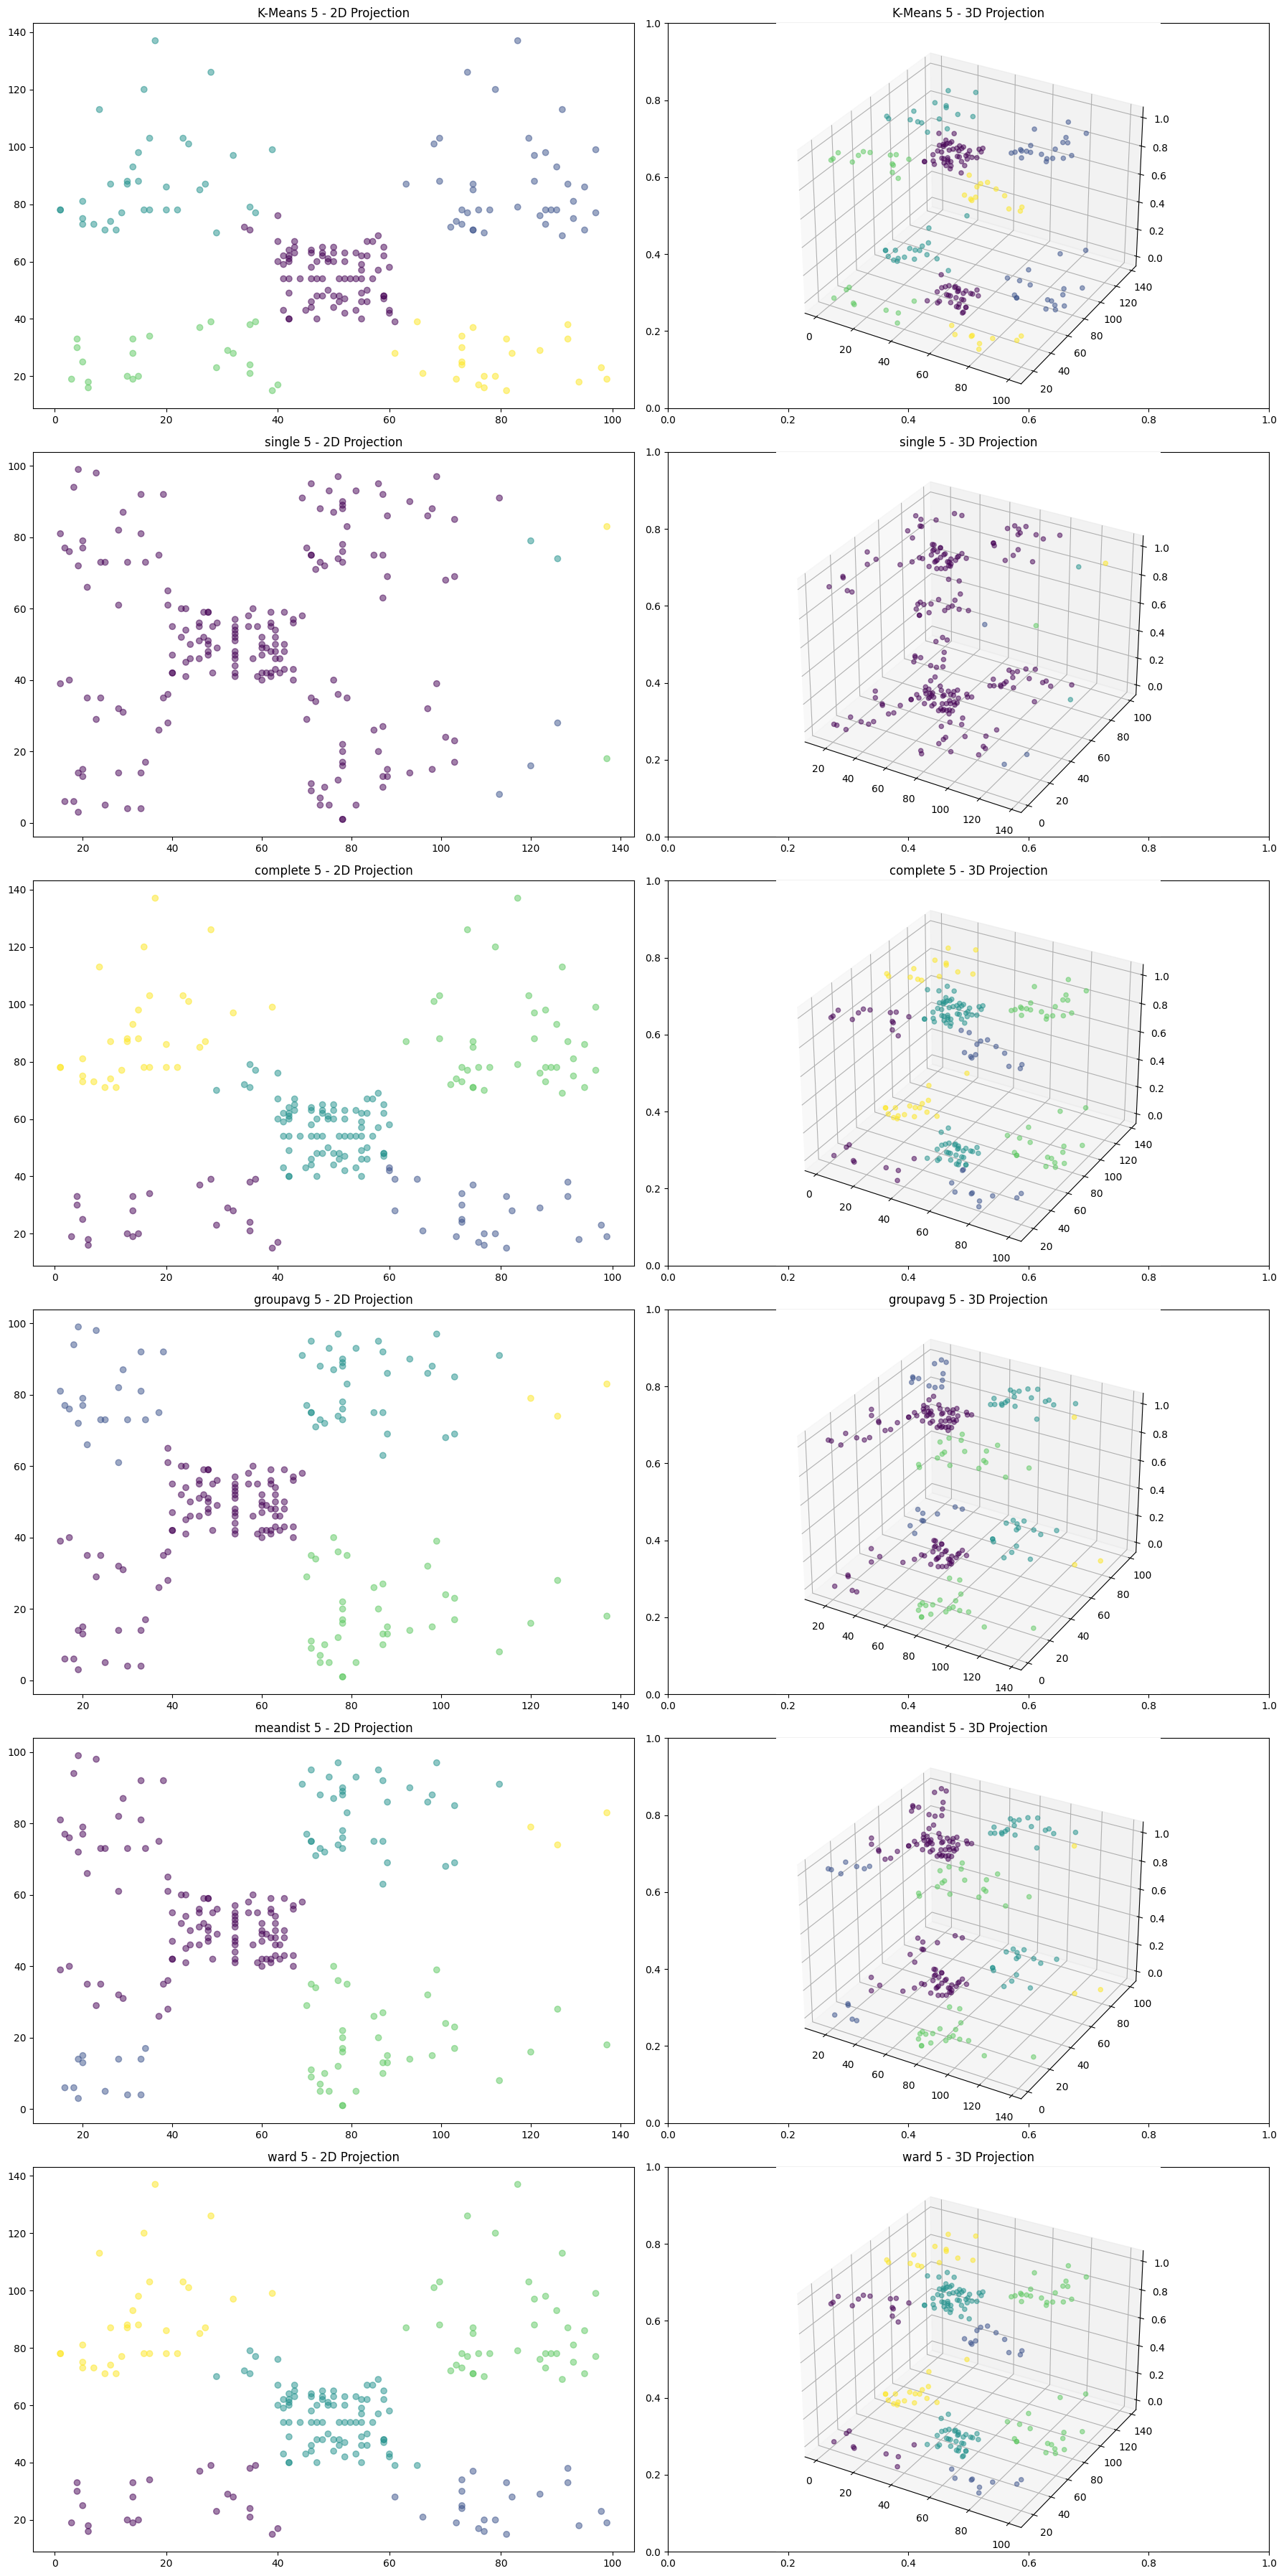

In [130]:
X_mall = df_mall.iloc[:, 2:].values
plot_subfigures(X_mall, 5)

Regarding the questions: Do you consider agglomerative clustering to be superior to k-Means? If so, which cluster distance metric do you prefer?

Let's address each dataset individually in order to draw conclusions about the overall analysis.

Mall_customers.csv

k-Means vs. Single | k-Means vs. Meandist

Both methods for calculating distance appear to be inadequate for the dataset, considering how the groups were initially selected. We find that the resulting clusters do not align well with the original data grouping.

k-Means vs. Complete | k-Means vs. Groupavg | k-Means vs. Ward

These methods yield results that are closest to k-Means, as they demonstrate a better alignment with the primary areas of interest.


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


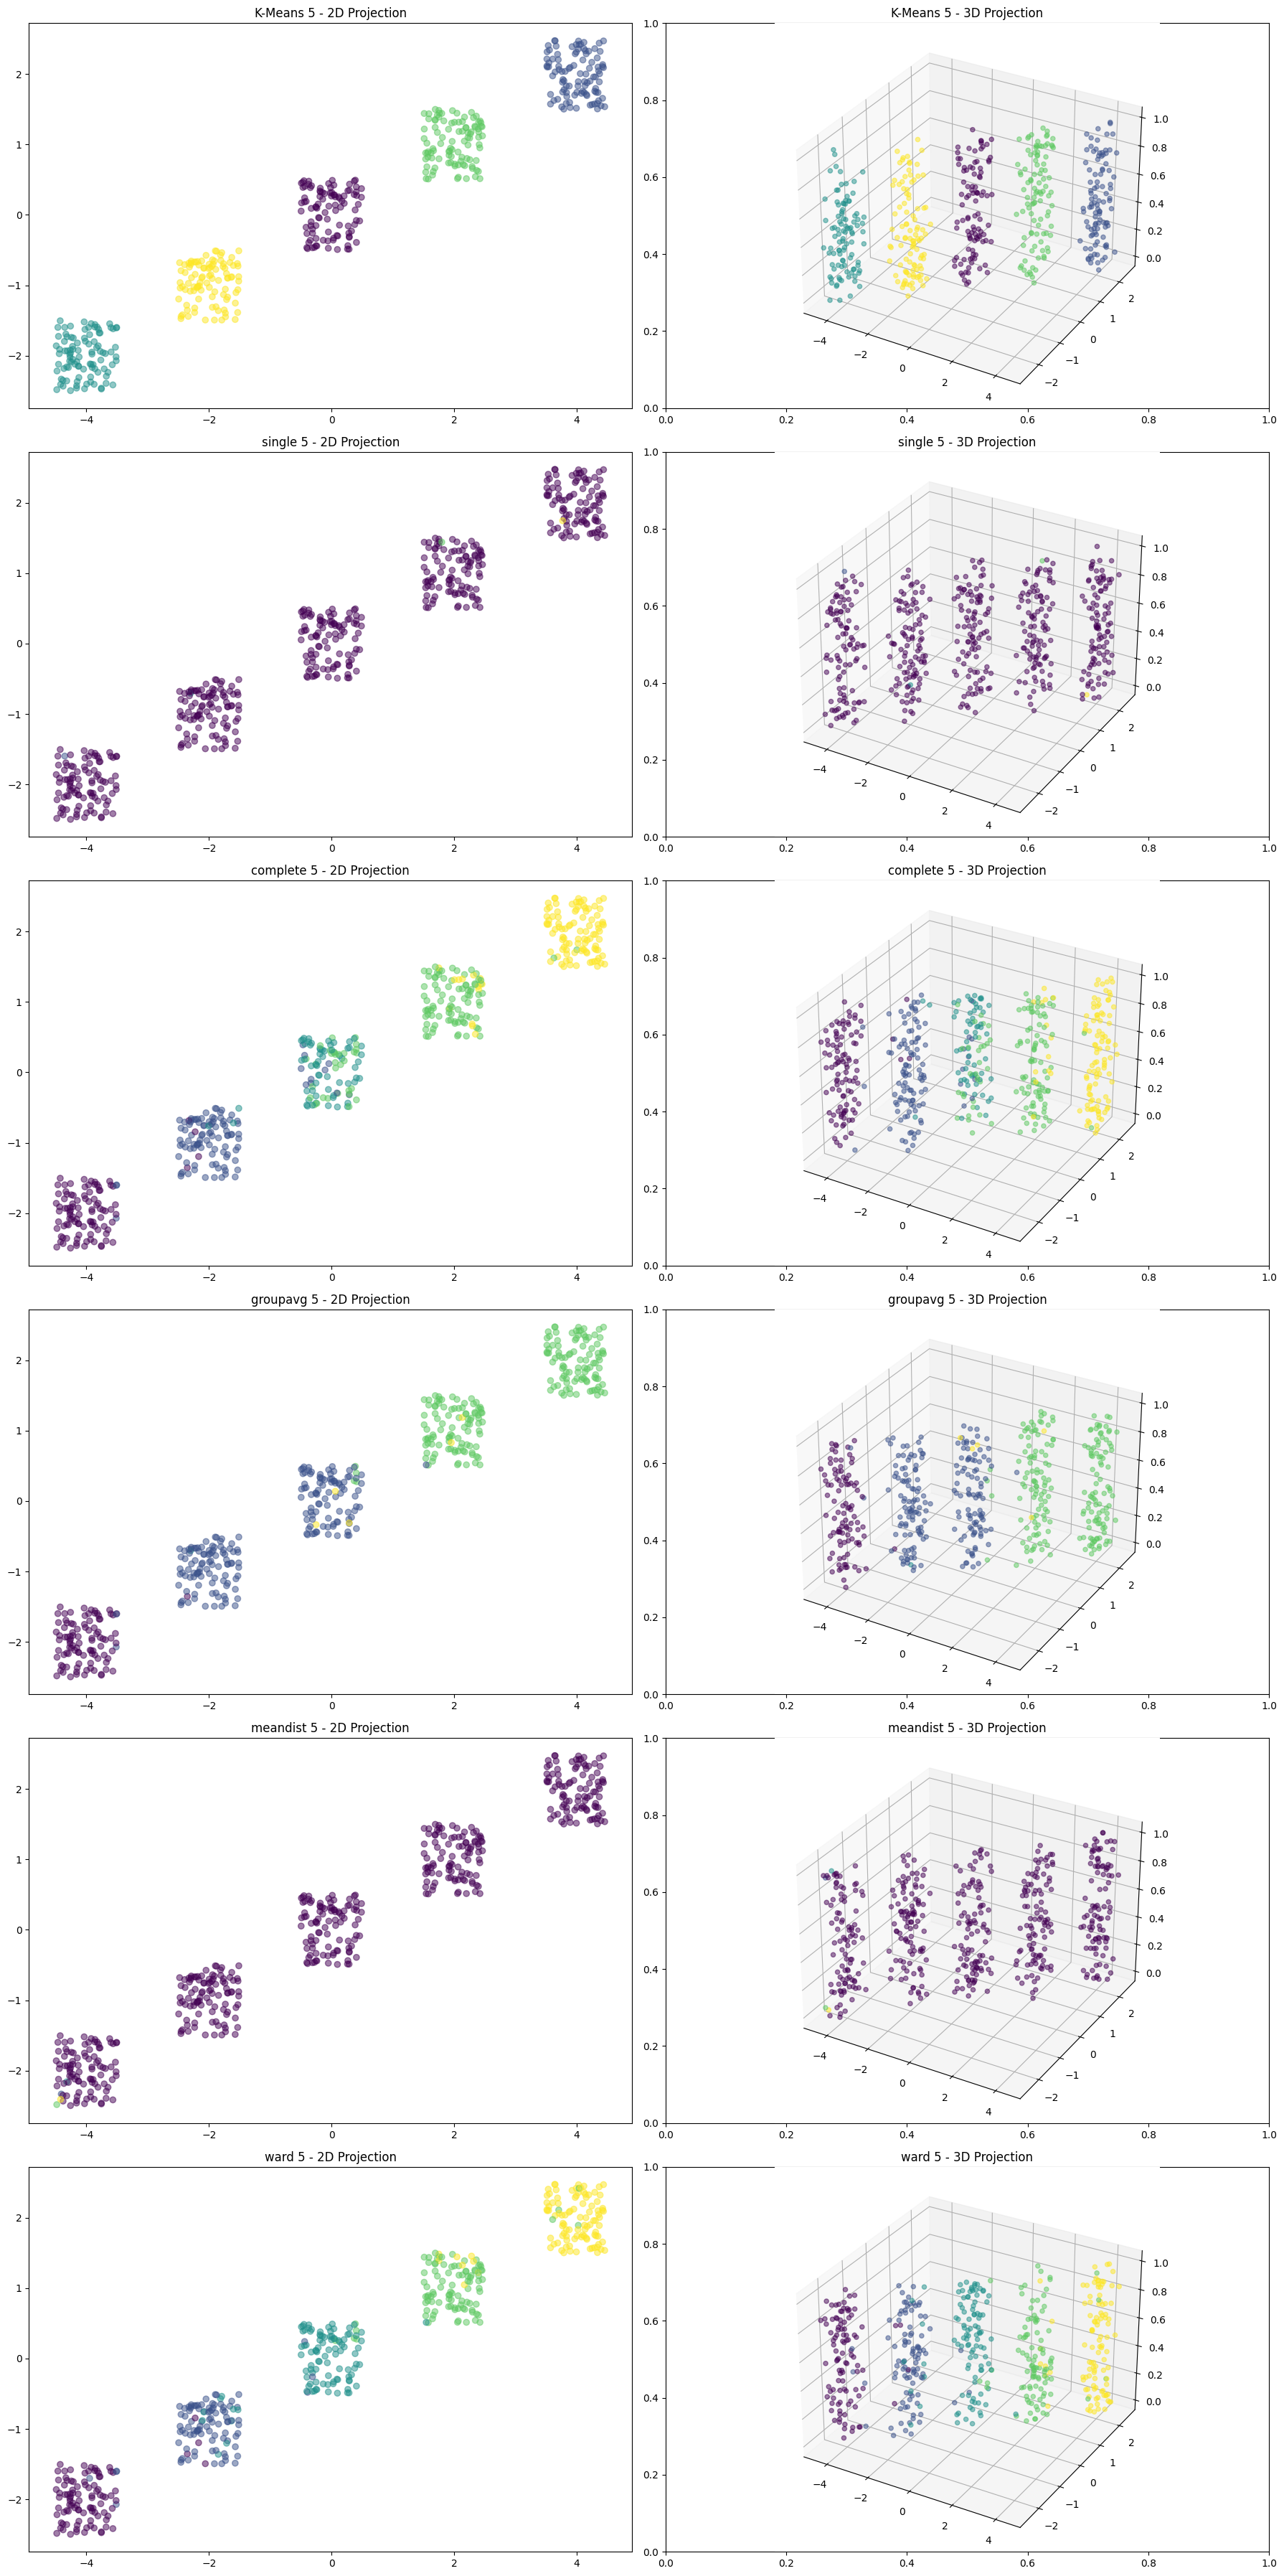

In [122]:
X_ridd = df_ridd.values
plot_subfigures(X_ridd, 5)

File Name: riddle.csv

k-Means vs. Single | k-Means vs. Meandist

Both methods for calculating the distance metric are incorrect for this dataset, as they once again lack the correct calculations needed to effectively partition the data for a more accurate interpretation.

k-Means vs. Complete | k-Means vs. Groupavg | k-Means vs. Ward

The results, although not as clean as one would hope when interpreting the data with k-Means, are much closer to what we would expect for a correct classification. Unfortunately, each group lacks well-defined individual clusters of just one type of data, as they somehow mix the data with other clusters, even with the easy readability that we could see in the 2D and 3D graphics.

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


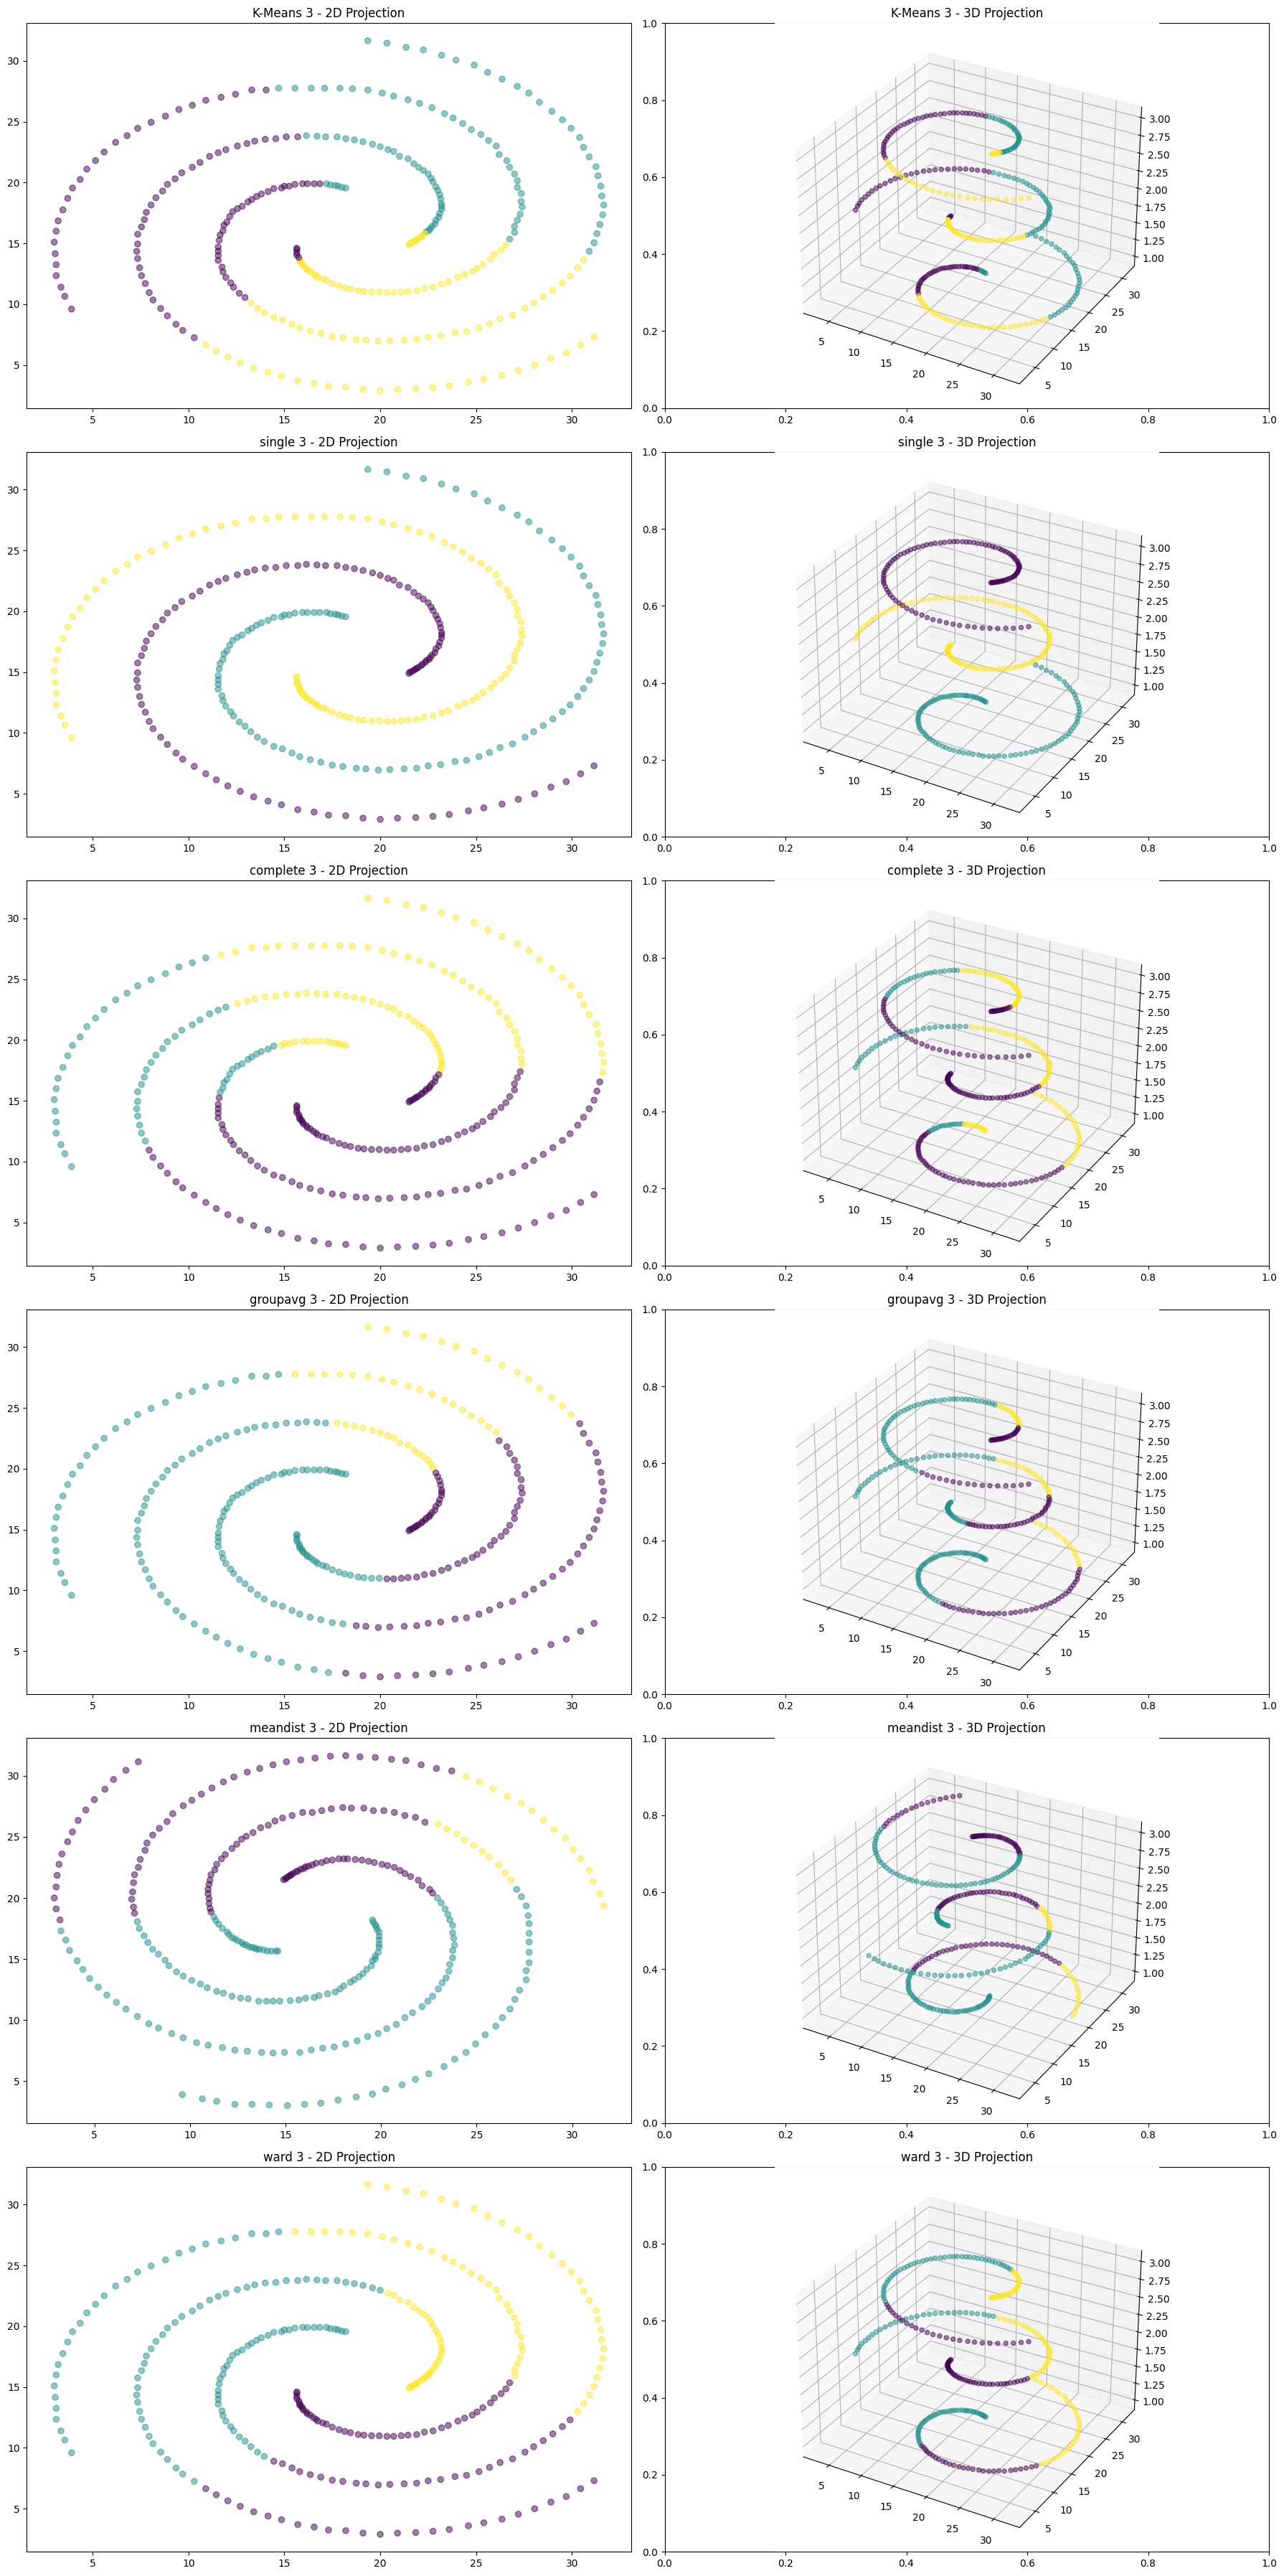

In [123]:
X_spir = df_spir.values
plot_subfigures(X_spir, 3)

spiral.csv

k-Means vs. Complete | k-Means vs. Meandist | k-Means vs. Groupavg | k-Means vs. Ward

Surprisingly, we found that all of these results are very close to the interpretation of how the data is divided into just three parts in every distance metric we calculated here. However, as a team, we didn't find this to be very close to what we would expect, as the 3D graphic doesn't provide a clear interpretation.

k-Means vs. Single

As a team, we discussed how this could easily be the best option for interpreting all the data represented in this dataset. We could easily observe a connection not only in the 2D projection but also in the 3D representation.

----------

Conclusion

In our comprehensive analysis of the entire dataset and various distance metrics, it is evident that kMeans is the closest clustering method to what one might expect in a 2D projection, even extending to 3D. However, when considering the specific dataset used in this exercise, we find that complete and Ward linkages closely approximate the performance of kMeans from a general perspective.

It's important to note that the synthetic data employed in this experiment serves as an approximation of the ideal dataset for our analytical purposes. Nevertheless, the strong correlation between the results obtained from these distance metrics and the kMeans method observed here suggests that it can be effectively employed as a reliable clustering technique overall.